
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#14computemodelperplexityandcoherencescore

https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc

https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyLDAvis 
!pip install pyLDAvis.gensim

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim


In [ ]:
import pandas as pd
import numpy as np
import re
port_data = pd.read_csv('/content/drive/MyDrive/Research Project/fdash_data_nonewlines.csv')
port_data2 = pd.read_csv('/content/drive/MyDrive/Research Project/Labeled OCR Data/OCR_Label_v3csv.csv')
#port_data.head()
df = pd.DataFrame(data=port_data)
labeled_data=pd.DataFrame(data=port_data2)
#df1 = df1.set_index('PolicyNo')
#df.head(10)

def clean_ocr(row):
  #cleaning out \n from ocr text and punctuation and lowercasing
  n_pattern = "\\n"
  punc = "[,\.!?]"
  fix_string = re.sub(n_pattern," ",str(row.ocr_text))
  fix_string = re.sub(punc," ",fix_string)
  return fix_string.lower()

#lowercasing and removing punctuation
df['ocr_text']=df.apply(clean_ocr,axis=1)

# Remove punctuation
#df['ocr_text_processed'] = \
#df['ocr_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Print out the first rows of papers
labeled_data.head()
labeled_data['Hand Label'].describe()


count           12035
unique             28
top       Not Labeled
freq            10920
Name: Hand Label, dtype: object

In [ ]:
#removing non labeled data
clean_label = labeled_data[labeled_data['Hand Label'].apply(lambda x: x.isnumeric())]
clean_label['Hand Label'].describe()

count     1115
unique      27
top         26
freq       347
Name: Hand Label, dtype: object

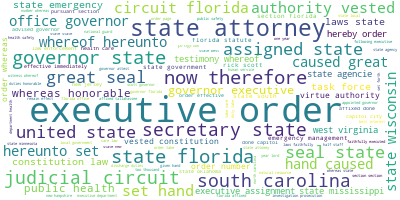

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['ocr_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'state', 'governor', 'therefore', 'whereas', 'shall', 'must', 'sign', 'document', 'order', 'executive', 'pursuant', 'issue', 'effective', 'follow','nsection','paragraph'])  # can find more stop words that are specific to Executive orders later


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [ ]:
# Convert to list
data = df.ocr_text.values.tolist()


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
num_topics = 35

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])

# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model with 35 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Print the Keyword in the topics
pprint(lda_model.print_topics(num_topics))
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


[(0,
  '0.100*"justice" + 0.061*"law" + 0.039*"enforcement" + 0.037*"criminal" + '
  '0.032*"danger" + 0.030*"arrest" + 0.029*"death" + 0.027*"victim" + '
  '0.023*"police" + 0.022*"deal"'),
 (1,
  '0.142*"fund" + 0.037*"expend" + 0.029*"amount" + 0.029*"project" + '
  '0.028*"pay" + 0.026*"cost" + 0.024*"expenditure" + 0.022*"year" + '
  '0.022*"page" + 0.020*"financial"'),
 (2,
  '0.049*"area" + 0.044*"district" + 0.043*"county" + 0.034*"local" + '
  '0.034*"fax" + 0.023*"town" + 0.022*"region" + 0.022*"taskforce" + '
  '0.020*"peace" + 0.018*"foot"'),
 (3,
  '0.219*"care" + 0.061*"health" + 0.041*"license" + 0.037*"provider" + '
  '0.036*"facility" + 0.024*"home" + 0.023*"service" + 0.022*"hospital" + '
  '0.022*"professional" + 0.021*"medical"'),
 (4,
  '0.052*"bond" + 0.047*"contract" + 0.033*"procurement" + 0.029*"amount" + '
  '0.020*"own" + 0.018*"project" + 0.017*"year" + 0.017*"activity" + '
  '0.015*"issue" + 0.015*"debt"'),
 (5,
  '0.077*"information" + 0.063*"drought" + 0.

https://stackoverflow.com/questions/17354417/gensim-how-to-save-lda-models-produced-topics-to-a-readable-format-csv-txt-et

In [ ]:
lda_model.save('lda_35_bigram.model')

In [ ]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()


#predicting topics on a new text
new_text = ['This order is trying to get rid of COVID and mandate that people where masks for the love of god. covid covid covid covid covid covid']
new_data_words = list(sent_to_words(new_text))
new_nostop = remove_stopwords(new_data_words)
new_bigram = make_bigrams(new_nostop)
new_lemmatized = lemmatization(new_bigram, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(new_lemmatized)
lda_model[id2word.doc2bow(new_lemmatized[0])]


lda_model.get_document_topics()

0: 0.100*"justice" + 0.061*"law" + 0.039*"enforcement" + 0.037*"criminal" + 0.032*"danger" + 0.030*"arrest" + 0.029*"death" + 0.027*"victim" + 0.023*"police" + 0.022*"deal"

1: 0.142*"fund" + 0.037*"expend" + 0.029*"amount" + 0.029*"project" + 0.028*"pay" + 0.026*"cost" + 0.024*"expenditure" + 0.022*"year" + 0.022*"page" + 0.020*"financial"

2: 0.049*"area" + 0.044*"district" + 0.043*"county" + 0.034*"local" + 0.034*"fax" + 0.023*"town" + 0.022*"region" + 0.022*"taskforce" + 0.020*"peace" + 0.018*"foot"

3: 0.219*"care" + 0.061*"health" + 0.041*"license" + 0.037*"provider" + 0.036*"facility" + 0.024*"home" + 0.023*"service" + 0.022*"hospital" + 0.022*"professional" + 0.021*"medical"

4: 0.052*"bond" + 0.047*"contract" + 0.033*"procurement" + 0.029*"amount" + 0.020*"own" + 0.018*"project" + 0.017*"year" + 0.017*"activity" + 0.015*"issue" + 0.015*"debt"

5: 0.077*"information" + 0.063*"drought" + 0.054*"system" + 0.032*"technology" + 0.020*"access" + 0.020*"datum" + 0.020*"security" + 0.

([(0, 0.017897304),
  (1, 0.011283024),
  (3, 0.013777632),
  (6, 0.011974173),
  (7, 0.010870741),
  (9, 0.048370115),
  (10, 0.08532229),
  (11, 0.011182154),
  (12, 0.082424484),
  (13, 0.14071749),
  (14, 0.078796476),
  (15, 0.018344482),
  (16, 0.019831428),
  (18, 0.018758653),
  (20, 0.02469767),
  (21, 0.022134166),
  (22, 0.010029784),
  (23, 0.018088773),
  (24, 0.08172508),
  (26, 0.021216832),
  (28, 0.010713043),
  (29, 0.026635814),
  (31, 0.01012566),
  (33, 0.12316548)],
 [(247, [12]),
  (401, [10, 9, 20]),
  (786, [24]),
  (856, [13, 12]),
  (2413, [14]),
  (2602, [33]),
  (8047, [13])],
 [(247, [(12, 0.9999839)]),
  (401, [(9, 0.24432139), (10, 0.7327383), (20, 0.022940207)]),
  (786, [(24, 1.0)]),
  (856, [(12, 0.03688999), (13, 0.95667416)]),
  (2413, [(14, 1.0)]),
  (2602, [(33, 0.99999994)]),
  (8047, [(13, 0.99999994)])])